# Gemini 1.5 Pro Multiple Choice Shuffled

In [1]:
import sys
from pathlib import Path

BASEDIR = Path("/workspaces/HARP/") / "src"  # Replace with your own basedir path for the repo

sys.path.insert(0, str(BASEDIR))

In [2]:
from __future__ import annotations

import copy
import itertools
import json
import math
import os
import pickle
import pprint
import re
import textwrap
import time
import traceback
from collections import Counter, defaultdict
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import tiktoken
from IPython.display import Markdown, clear_output, display
from tqdm.auto import tqdm

In [3]:
from eval.api import safe_unified_api_call
from eval.costs import count_tokens, get_pricing
from eval.eval import run_one, create_batch, make_answer_check_dict_from_jsonl, make_results_df, accuracy_by_split
from eval.parsing_lib import *
from eval.latex_answer_check import *
from eval.prompt import create_prompt
from eval.prompts import *
from eval.response import ModelResponse
from eval.utils import AMC_LETTER_CHOICES, read_jsonl, write_jsonl, get_uid

# Data

In [4]:
# We don't use HARP_mcq.jsonl here because we used the original ordering of answer choices
dataset = [x for x in read_jsonl(BASEDIR / "data/processed/HARP_raw.jsonl") if x["choices"] is not None and x["subject"] != "calculus"]
dataset_map = {get_uid(p): p for p in dataset}
len(dataset)

4110

In [5]:
with open(BASEDIR / "outputs/mcq/gemini-1.5-pro-002/mcq_derangements.pkl", "rb") as f:
    all_derangements = pickle.load(f)

In [8]:
TOTAL_RUNS = 5

def create_problem_with_shuffled_choices(prob, new_order):
    new_prob = prob.copy()
    
    new_choices = {}
    for letter, new_letter in zip(AMC_LETTER_CHOICES, new_order):
        new_choices[new_letter] = new_prob["choices"][letter]
    new_choices = {l: new_choices[l] for l in AMC_LETTER_CHOICES}
    new_prob["choices"] = new_choices
    new_prob["answer_choice"] = new_order[AMC_LETTER_CHOICES.index(new_prob["answer_choice"])]
    return new_prob

datasets = [[] for _ in range(TOTAL_RUNS)]
for prob in dataset:
    derangements = all_derangements[get_uid(prob)]
    choices = prob["choices"]
    length = 5
    if "none of" in choices["E"].lower() or "all of" in choices["E"].lower():
        length = 4

    for t in range(TOTAL_RUNS):
        datasets[t].append(
            create_problem_with_shuffled_choices(prob, derangements[t])
        )

datasets_map = [{get_uid(p): p for p in datasets[t]} for t in range(TOTAL_RUNS)]

# Results

In [9]:
raw_responses = []
responses = []
raw_response_map = []
response_map = []
answer_check_results = []
results = []

for i in range(5):
    fname = BASEDIR / f"outputs/mcq/gemini-1.5-pro-002/outputs_newline-paren_shuffle{i+1}.jsonl"

    raw_responses_shuffle_i = read_jsonl(fname)
    responses_shuffle_i = [
        {
            "uid": x["custom_id"],
            "system": x["request"]["system_instruction"],
            "prompt": x["request"]["contents"],
            "response": ModelResponse.from_response(x["response"], "google", use_batch_api=True)
        }
        for x in raw_responses_shuffle_i
        if x["custom_id"] in dataset_map
    ]
    raw_response_shuffle_i_map = {x["custom_id"]: x for x in raw_responses_shuffle_i if x["custom_id"] in dataset_map}
    response_shuffle_i_map = {o["uid"]: o for o in responses_shuffle_i}

    answer_check_dicts_shuffle_i = make_answer_check_dict_from_jsonl(responses_shuffle_i, datasets_map[i])
    answer_check_results_shuffle_i = latex_answer_choice_check(answer_check_dicts_shuffle_i, use_tqdm=True)
    results_shuffle_i_metadata = make_results_df(responses_shuffle_i, answer_check_results_shuffle_i, datasets_map[i], mode="mcq")

    raw_responses.append(raw_responses_shuffle_i)
    responses.append(responses_shuffle_i)
    raw_response_map.append(raw_response_shuffle_i_map)
    response_map.append(response_shuffle_i_map)
    answer_check_results.append(answer_check_results_shuffle_i)
    results.append(results_shuffle_i_metadata)

  0%|          | 0/4110 [00:00<?, ?it/s]

  0%|          | 0/4110 [00:00<?, ?it/s]

  0%|          | 0/4110 [00:00<?, ?it/s]

  0%|          | 0/4110 [00:00<?, ?it/s]

  0%|          | 0/4110 [00:00<?, ?it/s]

In [10]:
for i in range(5):
    print(
        "Accuracy is {} / {} = {:.01f}%".format(
            results[i]["is_correct"].sum(),
            len(results[i]),
            results[i]["is_correct"].sum() / len(results[i]) * 100,
        )
    )

Accuracy is 3316 / 4110 = 80.7%
Accuracy is 3328 / 4110 = 81.0%
Accuracy is 3307 / 4110 = 80.5%
Accuracy is 3282 / 4110 = 79.9%
Accuracy is 3302 / 4110 = 80.3%


In [11]:
for i in range(5):
    RESULTS_FNAME = BASEDIR / f"results/gemini-1.5-pro-002/results_mcq_newlineparen_shuffle{i+1}.csv"
    results[i].to_csv(RESULTS_FNAME)

## Accuracy

In [12]:
for i in range(5):
    print(accuracy_by_split(results[i], "level"))

       count   accuracy
level                  
1        858  87.412587
2       1612  85.359801
3       1136  76.056338
4        504  64.682540
       count   accuracy
level                  
1        858  86.713287
2       1612  85.732010
3       1136  77.816901
4        504  63.095238
       count   accuracy
level                  
1        858  87.179487
2       1612  85.359801
3       1136  76.232394
4        504  62.896825
       count   accuracy
level                  
1        858  86.130536
2       1612  84.739454
3       1136  77.200704
4        504  59.523810
       count   accuracy
level                  
1        858  87.062937
2       1612  84.615385
3       1136  76.584507
4        504  63.690476


In [13]:
for i in range(5):
    print(accuracy_by_split(results[i], "subject"))

                          count   accuracy
subject                                   
algebra                     872  86.353211
counting_and_probability    600  71.333333
geometry                   1071  72.362278
number_theory               473  78.858351
prealgebra                  957  92.685475
precalculus                 137  72.992701
                          count   accuracy
subject                                   
algebra                     872  87.041284
counting_and_probability    600  72.500000
geometry                   1071  73.482726
number_theory               473  80.126850
prealgebra                  957  91.222571
precalculus                 137  69.343066
                          count   accuracy
subject                                   
algebra                     872  85.206422
counting_and_probability    600  72.166667
geometry                   1071  73.295985
number_theory               473  78.858351
prealgebra                  957  91.431557
precalculus

In [14]:
for i in range(5):
    print(results[i][~results[i]["mcq_only"]]["is_correct"].mean() * 100)

80.27390044772189
80.53726626283908
80.08954437713984
79.24677376876481
79.95786146958125


In [15]:
for i in range(5):
    print(accuracy_by_split(results[i][~results[i]["mcq_only"]], "level"))

       count   accuracy
level                  
1        799  86.983730
2       1505  84.983389
3       1036  75.482625
4        457  63.894967
       count   accuracy
level                  
1        799  86.232791
2       1505  85.249169
3       1036  77.509653
4        457  61.925602
       count   accuracy
level                  
1        799  86.608260
2       1505  84.983389
3       1036  75.675676
4        457  62.582057
       count   accuracy
level                  
1        799  85.607009
2       1505  84.119601
3       1036  76.640927
4        457  57.986871
       count   accuracy
level                  
1        799  86.608260
2       1505  84.252492
3       1036  76.158301
4        457  62.800875


## Compare with no-shuffle

In [16]:
fname_newlineparen = BASEDIR / "outputs/mcq/gemini-1.5-pro-002/outputs_newline-paren.jsonl"

raw_responses_newlineparen = read_jsonl(fname_newlineparen)
responses_newlineparen = [
    {
        "uid": x["custom_id"],
        "system": x["request"]["system_instruction"],
        "prompt": x["request"]["contents"],
        "response": ModelResponse.from_response(x["response"], "google", use_batch_api=True)
    }
    for x in raw_responses_newlineparen
    if x["custom_id"] in dataset_map
]
raw_response_newlineparen_map = {x["custom_id"]: x for x in raw_responses_newlineparen if x["custom_id"] in dataset_map}
response_newlineparen_map = {o["uid"]: o for o in responses_newlineparen}

answer_check_dicts_newlineparen = make_answer_check_dict_from_jsonl(responses_newlineparen, dataset_map)
answer_check_results_newlineparen = latex_answer_choice_check(answer_check_dicts_newlineparen, use_tqdm=True)
results_metadata_newlineparen = make_results_df(responses_newlineparen, answer_check_results_newlineparen, dataset_map, mode="mcq")

  0%|          | 0/4110 [00:00<?, ?it/s]

In [17]:
ACCURACY_COLUMNS = [
    "is_correct_original",
    *[f"is_correct_shuffle_{i+1}" for i in range(5)],
]

In [18]:
df = pd.concat([
    (
        results_metadata_newlineparen
        .set_index(["level", "subject", "has_asy_problem", "has_asy_solution", "mcq_only"], append=True)
        .assign(mode="original")
    ),
    *[
        (
            results[i]
            .set_index(["level", "subject", "has_asy_problem", "has_asy_solution", "mcq_only"], append=True)
            .assign(mode=f"shuffle_{i+1}")
        )
        for i in range(5)
    ]
]).set_index("mode", append=True)

In [19]:
df = df.unstack("mode")
df.columns = df.columns.map("_".join)
df = df.reset_index().set_index("uid")
df["num_correct"] = df[ACCURACY_COLUMNS].sum(axis=1)
df.head()

,level,subject,has_asy_problem,has_asy_solution,mcq_only,reason_original,reason_shuffle_1,reason_shuffle_2,reason_shuffle_3,reason_shuffle_4,...,output_tokens_shuffle_3,output_tokens_shuffle_4,output_tokens_shuffle_5,reasoning_tokens_original,reasoning_tokens_shuffle_1,reasoning_tokens_shuffle_2,reasoning_tokens_shuffle_3,reasoning_tokens_shuffle_4,reasoning_tokens_shuffle_5,num_correct
uid,,,,,,,,,,,,,,,,,,,,,
1950/AHSME/1,2,prealgebra,False,False,False,stop,stop,stop,stop,stop,...,148,148,143,0,0,0,0,0,0,6
1950/AHSME/10,2,prealgebra,False,False,False,stop,stop,stop,stop,stop,...,240,257,317,0,0,0,0,0,0,3
1950/AHSME/11,2,prealgebra,False,False,True,stop,stop,stop,stop,stop,...,228,206,215,0,0,0,0,0,0,6
1950/AHSME/12,2,geometry,False,False,True,stop,stop,stop,stop,stop,...,176,175,185,0,0,0,0,0,0,6
1950/AHSME/13,2,algebra,False,False,False,stop,stop,stop,stop,stop,...,226,208,223,0,0,0,0,0,0,6


In [20]:
def plot_intersect_accuracy(
    df,
    title="Common accuracy of multiple shuffled MCQ runs on Gemini 1.5 Pro v2",
):
    print(df[ACCURACY_COLUMNS].mean())
    print("Average 1 model perf:", df[ACCURACY_COLUMNS].mean().mean())
    
    single_bootstrap_res = stats.bootstrap((df[ACCURACY_COLUMNS].mean().to_numpy(),), np.mean, confidence_level=0.95)
    print("Single accuracy: {:.02f} +/- {:.02f}".format(
        100 * df[ACCURACY_COLUMNS].mean().mean(),
        100 * (single_bootstrap_res.confidence_interval.high - single_bootstrap_res.confidence_interval.low) / 2
    ))
    
    all_pair_acc = []
    for i, col1 in enumerate(ACCURACY_COLUMNS):
        for col2 in ACCURACY_COLUMNS[i+1:]:
            pair_acc = df[[col1, col2]].prod(axis=1).mean()
            all_pair_acc.append(pair_acc)
            # print(f"{col1} & {col2}: {pair_acc}")
    
    pair_bootstrap_res = stats.bootstrap((all_pair_acc,), np.mean, confidence_level=0.95)
    print("2-intersect accuracy: {:.02f} +/- {:.02f}".format(
        100 * sum(all_pair_acc) / len(all_pair_acc),
        100 * (pair_bootstrap_res.confidence_interval.high - pair_bootstrap_res.confidence_interval.low) / 2
    ))
    
    all_trio_acc = []
    for i, col1 in enumerate(ACCURACY_COLUMNS):
        for j, col2 in enumerate(ACCURACY_COLUMNS[i+1:]):
            for k, col3 in enumerate(ACCURACY_COLUMNS[j+1:]):
                acc = df[[col1, col2, col3]].prod(axis=1).mean()
                all_trio_acc.append(acc)
                # print(f"{col1.split('is_correct_')[1]} & {col2.split('is_correct_')[1]} & {col3.split('is_correct_')[1]}: {acc}")
    
    trio_bootstrap_res = stats.bootstrap((all_trio_acc,), np.mean, confidence_level=0.95)
    print("3-intersect accuracy: {:.02f} +/- {:.02f}".format(
        100 * sum(all_trio_acc) / len(all_trio_acc),
        100 * (trio_bootstrap_res.confidence_interval.high - trio_bootstrap_res.confidence_interval.low) / 2
    ))
    
    all_quad_acc = []
    for i, col1 in enumerate(ACCURACY_COLUMNS):
        for j, col2 in enumerate(ACCURACY_COLUMNS[i+1:]):
            for k, col3 in enumerate(ACCURACY_COLUMNS[j+1:]):
                for l, col4 in enumerate(ACCURACY_COLUMNS[k+1:]):
                    acc = df[[col1, col2, col3, col4]].prod(axis=1).mean()
                    all_quad_acc.append(acc)
    
    quad_bootstrap_res = stats.bootstrap((all_quad_acc,), np.mean, confidence_level=0.95)
    print("4-intersect accuracy: {:.02f} +/- {:.02f}".format(
        100 * sum(all_quad_acc) / len(all_quad_acc),
        100 * (quad_bootstrap_res.confidence_interval.high - quad_bootstrap_res.confidence_interval.low) / 2
    ))
    
    all_quin_acc = []
    for i, col1 in enumerate(ACCURACY_COLUMNS):
        acc = df[[col for col in ACCURACY_COLUMNS if col != col1]].prod(axis=1).mean()
        all_quin_acc.append(acc)
    
    quin_bootstrap_res = stats.bootstrap((all_quin_acc,), np.mean, confidence_level=0.95)
    print("5-intersect accuracy: {:.02f} +/- {:.02f}".format(
        100 * sum(all_quin_acc) / len(all_quin_acc),
        100 * (quin_bootstrap_res.confidence_interval.high - quin_bootstrap_res.confidence_interval.low) / 2
    ))
    
    all6_accuracy = df["is_correct_original"].copy()
    for c in ACCURACY_COLUMNS[1:]:
        all6_accuracy *= df[c]
    print(f"All-6 accuracy: {all6_accuracy.mean()*100:.02f}")
    
    xs = list(range(1,6))
    accs = np.array([
        100 * df[ACCURACY_COLUMNS].mean().mean(),
        100 * sum(all_pair_acc) / len(all_pair_acc),
        100 * sum(all_trio_acc) / len(all_trio_acc),
        100 * sum(all_quad_acc) / len(all_quad_acc),
        100 * sum(all_quin_acc) / len(all_quin_acc),
    ])
    cis = np.array([
        100 * (single_bootstrap_res.confidence_interval.high - single_bootstrap_res.confidence_interval.low) / 2,
        100 * (pair_bootstrap_res.confidence_interval.high - pair_bootstrap_res.confidence_interval.low) / 2,
        100 * (trio_bootstrap_res.confidence_interval.high - trio_bootstrap_res.confidence_interval.low) / 2,
        100 * (quad_bootstrap_res.confidence_interval.high - quad_bootstrap_res.confidence_interval.low) / 2,
        100 * (quin_bootstrap_res.confidence_interval.high - quin_bootstrap_res.confidence_interval.low) / 2,
    ])
    
    fig, ax = plt.subplots()
    ax.plot(xs, accs)
    ax.fill_between(xs, (accs-cis), (accs+cis), color='b', alpha=.1)
    
    plt.xticks(np.arange(1, 6, 1.0))
    plt.xlabel("Number of runs to intersect")
    plt.ylabel("Accuracy (%)")
    plt.title(title)
    plt.grid(True)
    plt.show()

is_correct_original     0.810949
is_correct_shuffle_1    0.806813
is_correct_shuffle_2    0.809732
is_correct_shuffle_3    0.804623
is_correct_shuffle_4    0.798540
is_correct_shuffle_5    0.803406
dtype: float64
Average 1 model perf: 0.8056772100567721
Single accuracy: 80.57 +/- 0.33
2-intersect accuracy: 73.89 +/- 0.21
3-intersect accuracy: 71.55 +/- 0.48
4-intersect accuracy: 70.10 +/- 0.26
5-intersect accuracy: 65.99 +/- 0.19
All-6 accuracy: 64.57


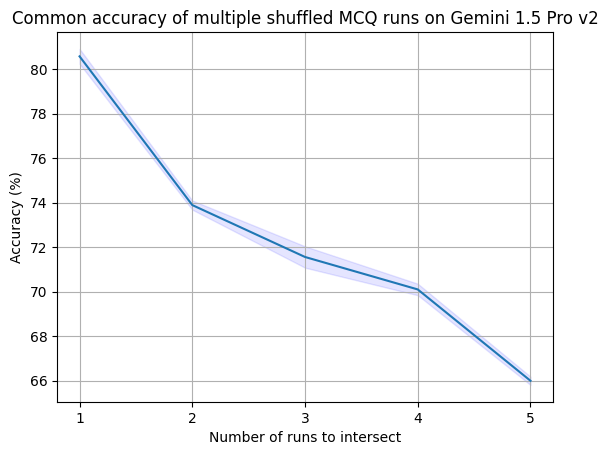

In [21]:
plot_intersect_accuracy(df)

is_correct_original     0.807216
is_correct_shuffle_1    0.802739
is_correct_shuffle_2    0.805373
is_correct_shuffle_3    0.800895
is_correct_shuffle_4    0.792468
is_correct_shuffle_5    0.799579
dtype: float64
Average 1 model perf: 0.8013782810991135
Single accuracy: 80.14 +/- 0.39
2-intersect accuracy: 73.40 +/- 0.21
3-intersect accuracy: 71.04 +/- 0.48
4-intersect accuracy: 69.58 +/- 0.26
5-intersect accuracy: 65.49 +/- 0.18
All-6 accuracy: 64.08


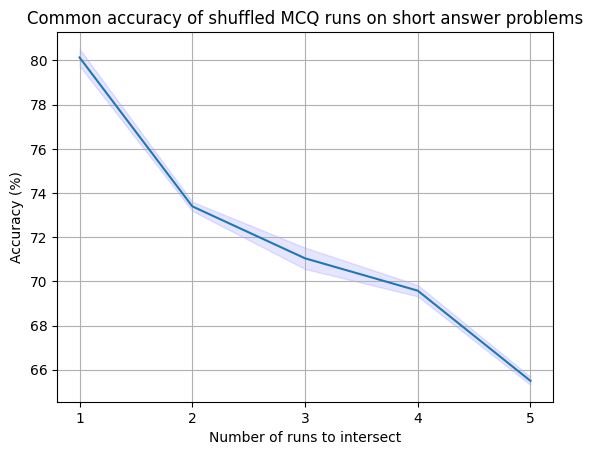

In [22]:
plot_intersect_accuracy(df[~df["mcq_only"]], title="Common accuracy of shuffled MCQ runs on short answer problems")

In [23]:
df[~df["mcq_only"]]["num_correct"].value_counts().sort_index()

num_correct
0     233
1     194
2     212
3     182
4     220
5     323
6    2433
Name: count, dtype: int64

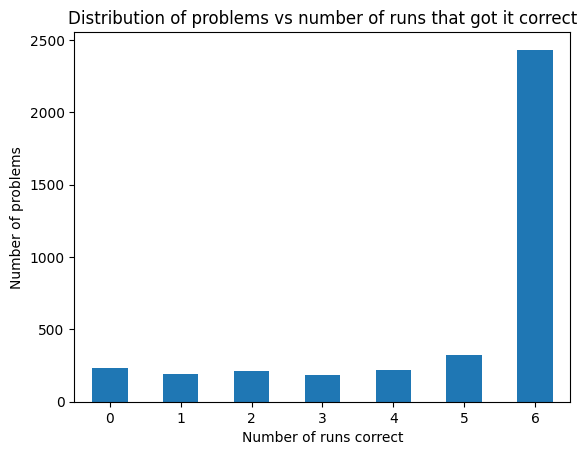

In [24]:
ax = df[~df["mcq_only"]]["num_correct"].value_counts().sort_index().plot(kind='bar')

plt.xlabel("Number of runs correct")
plt.xticks(rotation=0)
plt.ylabel("Number of problems")
plt.title("Distribution of problems vs number of runs that got it correct")
plt.show()

In [25]:
df.value_counts([
    "is_correct_original",
    "is_correct_shuffle_1",
    "is_correct_shuffle_2",
]).sort_index()

is_correct_original  is_correct_shuffle_1  is_correct_shuffle_2
False                False                 False                    398
                                           True                     132
                     True                  False                    112
                                           True                     135
True                 False                 False                    118
                                           True                     146
                     True                  False                    154
                                           True                    2915
Name: count, dtype: int64

In [27]:
2915 / len(results_metadata_newlineparen) * 100

70.92457420924573

In [28]:
df.value_counts([
    "level",
    "is_correct_original",
    "is_correct_shuffle_1",
    "is_correct_shuffle_2",
]).sort_index()

level  is_correct_original  is_correct_shuffle_1  is_correct_shuffle_2
1      False                False                 False                     56
                                                  True                      16
                            True                  False                     17
                                                  True                      17
       True                 False                 False                     20
                                                  True                      16
                            True                  False                     21
                                                  True                     695
2      False                False                 False                    115
                                                  True                      38
                            True                  False                     28
                                                  True      

In [29]:
df[
    [not dataset_map[x]["multiple_choice_only"] for x in df.index.get_level_values("uid")]
].value_counts([
    "is_correct_original",
    "is_correct_shuffle_1",
    "is_correct_shuffle_2",
]).sort_index()

is_correct_original  is_correct_shuffle_1  is_correct_shuffle_2
False                False                 False                    379
                                           True                     122
                     True                  False                    105
                                           True                     126
True                 False                 False                    111
                                           True                     137
                     True                  False                    144
                                           True                    2673
Name: count, dtype: int64

In [30]:
2673 / len(df[[not dataset_map[x]["multiple_choice_only"] for x in df.index.get_level_values("uid")]])

0.7039768238082696

In [31]:
df[
    [not dataset_map[x]["multiple_choice_only"] for x in df.index.get_level_values("uid")]
].value_counts([
    "level",
    "is_correct_original",
    "is_correct_shuffle_1",
    "is_correct_shuffle_2",
]).sort_index()

level  is_correct_original  is_correct_shuffle_1  is_correct_shuffle_2
1      False                False                 False                     55
                                                  True                      15
                            True                  False                     16
                                                  True                      17
       True                 False                 False                     19
                                                  True                      15
                            True                  False                     20
                                                  True                     642
2      False                False                 False                    110
                                                  True                      35
                            True                  False                     27
                                                  True      

## Compare with short answer

In [33]:
responses_shortans = [
    {
        "uid": x["custom_id"],
        "system": x["request"]["system_instruction"],
        "prompt": x["request"]["contents"],
        "response": ModelResponse.from_response(x["response"], "google", use_batch_api=True)
    }
    for x in read_jsonl(BASEDIR / "outputs/short_answer/gemini-1.5-pro-002/outputs.jsonl")
]
response_shortans_map = {o["uid"]: o for o in responses_shortans}

In [34]:
shortans_res = pd.read_csv(BASEDIR / "results/gemini-1.5-pro-002/results.csv").set_index("uid")

In [35]:
shortans_res[["AIME" not in x for x in shortans_res.index]].query("subject != 'calculus'")["is_correct"].mean()

np.float64(0.6423492230708454)

In [36]:
shortans_res.head()

,level,subject,mcq_only,has_asy_problem,has_asy_solution,reason,is_correct,answer,predict,input_tokens,output_tokens,reasoning_tokens
uid,,,,,,,,,,,,
1984/AIME/10,5,algebra,False,False,False,stop,False,$119$,85,202,948,0
2010/AMC_12B/20,3,precalculus,False,False,False,stop,False,$8$,4,118,894,0
1964/AHSME/7,2,algebra,False,False,False,stop,True,$2$,2,93,365,0
2018/AMC_10A/19,2,counting_and_probability,False,False,False,stop,True,$\frac{2}{5}$,\frac{2}{5},136,833,0
2002/AIME_I/11,5,geometry,False,False,False,stop,False,$230$,25,202,833,0


In [37]:
df.head()

,level,subject,has_asy_problem,has_asy_solution,mcq_only,reason_original,reason_shuffle_1,reason_shuffle_2,reason_shuffle_3,reason_shuffle_4,...,output_tokens_shuffle_3,output_tokens_shuffle_4,output_tokens_shuffle_5,reasoning_tokens_original,reasoning_tokens_shuffle_1,reasoning_tokens_shuffle_2,reasoning_tokens_shuffle_3,reasoning_tokens_shuffle_4,reasoning_tokens_shuffle_5,num_correct
uid,,,,,,,,,,,,,,,,,,,,,
1950/AHSME/1,2,prealgebra,False,False,False,stop,stop,stop,stop,stop,...,148,148,143,0,0,0,0,0,0,6
1950/AHSME/10,2,prealgebra,False,False,False,stop,stop,stop,stop,stop,...,240,257,317,0,0,0,0,0,0,3
1950/AHSME/11,2,prealgebra,False,False,True,stop,stop,stop,stop,stop,...,228,206,215,0,0,0,0,0,0,6
1950/AHSME/12,2,geometry,False,False,True,stop,stop,stop,stop,stop,...,176,175,185,0,0,0,0,0,0,6
1950/AHSME/13,2,algebra,False,False,False,stop,stop,stop,stop,stop,...,226,208,223,0,0,0,0,0,0,6


In [40]:
df_all = pd.merge(
    shortans_res.set_index(["level", "subject", "has_asy_problem", "has_asy_solution"], append=True),
    df.set_index(["level", "subject", "has_asy_problem", "has_asy_solution"], append=True),
    left_index=True,
    right_index=True,
    how="inner"
).reset_index().set_index("uid")

In [41]:
len(df_all)

3797

In [42]:
df_all[["reason", "reason_original", "reason_shuffle_1", "reason_shuffle_2"]].value_counts()

reason     reason_original  reason_shuffle_1  reason_shuffle_2
stop       stop             stop              stop                3721
                            length            stop                  24
                            stop              length                24
           length           stop              stop                  12
           stop             length            length                 3
                            stop              copyright              3
length     stop             stop              stop                   3
stop       stop             copyright         stop                   2
           length           stop              length                 2
           copyright        copyright         copyright              1
copyright  stop             stop              stop                   1
length     stop             length            stop                   1
Name: count, dtype: int64

In [43]:
df_all[["is_correct", "is_correct_original", "is_correct_shuffle_1", "is_correct_shuffle_2"]].value_counts() / len(df_all)

is_correct  is_correct_original  is_correct_shuffle_1  is_correct_shuffle_2
True        True                 True                  True                    0.571240
False       True                 True                  True                    0.132736
            False                False                 False                   0.088491
                                                       True                    0.025020
            True                 True                  False                   0.024230
            False                True                  False                   0.022386
            True                 False                 True                    0.022123
            False                True                  True                    0.021333
            True                 False                 False                   0.021333
True        True                 False                 True                    0.013958
                                 True       

In [44]:
df_all.query("is_correct")[["is_correct_original", "is_correct_shuffle_1", "is_correct_shuffle_2"]].value_counts() / len(df_all.query("is_correct"))

is_correct_original  is_correct_shuffle_1  is_correct_shuffle_2
True                 True                  True                    0.889299
                     False                 True                    0.021730
                     True                  False                   0.021320
False                True                  True                    0.018450
                     False                 False                   0.017630
True                 False                 False                   0.012300
False                False                 True                    0.011070
                     True                  False                   0.008200
Name: count, dtype: float64

In [45]:
df_all.query("~is_correct")[["is_correct_original", "is_correct_shuffle_1", "is_correct_shuffle_2"]].value_counts() / len(df_all.query("~is_correct"))

is_correct_original  is_correct_shuffle_1  is_correct_shuffle_2
True                 True                  True                    0.371134
False                False                 False                   0.247423
                                           True                    0.069956
True                 True                  False                   0.067747
False                True                  False                   0.062592
True                 False                 True                    0.061856
False                True                  True                    0.059647
True                 False                 False                   0.059647
Name: count, dtype: float64

In [46]:
df_all.loc["2024/AMC_8/1"]

level                                     1
subject                       number_theory
has_asy_problem                       False
has_asy_solution                      False
mcq_only_x                            False
reason                                 stop
is_correct                             True
answer                                  $2$
predict                                   2
input_tokens                            100
output_tokens                           493
reasoning_tokens                          0
mcq_only_y                            False
reason_original                        stop
reason_shuffle_1                       stop
reason_shuffle_2                       stop
reason_shuffle_3                       stop
reason_shuffle_4                       stop
reason_shuffle_5                       stop
is_correct_original                   False
is_correct_shuffle_1                  False
is_correct_shuffle_2                   True
is_correct_shuffle_3            

In [48]:
rand_uid = np.random.choice(
    df_all
    .query("reason == 'stop' and reason_original == 'stop' and reason_shuffle_1 == 'stop' and reason_shuffle_2 == 'stop'")
    .query("is_correct and (not is_correct_original or not is_correct_shuffle_1 or not is_correct_shuffle_2)")
    .index
)

# had the right answer, but picked the wrong answer choice
# rand_uid = "1996/AHSME/15"

# rand_uid = "2012/AMC_10A/4"

print(rand_uid)
print(dataset_map[rand_uid]["subject"], dataset_map[rand_uid]["level"])
print(df_all[["is_correct", "is_correct_original", "is_correct_shuffle_1", "is_correct_shuffle_2"]].loc[rand_uid])
print("----------")
print(dataset_map[rand_uid]["answer_choice"])
print(dataset_map[rand_uid]["answer"])
print(dataset_map[rand_uid]["choices"])
print(response_shortans_map[rand_uid]["prompt"][-2]["parts"][0]["text"])
display(Markdown(response_shortans_map[rand_uid]["response"].completions[0].completion))
print("----------")
display(Markdown(response_newlineparen_map[rand_uid]["response"].completions[0].completion))
print("----------")
print(datasets_map[0][rand_uid]["answer_choice"])
print(datasets_map[0][rand_uid]["answer"])
print(datasets_map[0][rand_uid]["choices"])
display(Markdown(response_map[0][rand_uid]["response"].completions[0].completion))

2022/AMC_10A/15
geometry 2
is_correct               True
is_correct_original      True
is_correct_shuffle_1    False
is_correct_shuffle_2    False
Name: 2022/AMC_10A/15, dtype: bool
----------
D
$1565$
{'A': '$260$', 'B': '$855$', 'C': '$1235$', 'D': '$1565$', 'E': '$1997$'}
Problem:
Quadrilateral $ABCD$ with side lengths $AB=7, BC=24, CD=20, DA=15$ is inscribed in a circle. The area interior to the circle but exterior to the quadrilateral can be written in the form $\frac{a\pi-b}{c},$ where $a,b,$ and $c$ are positive integers such that $a$ and $c$ have no common prime factor. What is $a+b+c?$


Let the quadrilateral be $ABCD$. We are given $AB=7, BC=24, CD=20, DA=15$. Since the quadrilateral is inscribed in a circle, we can use Ptolemy's theorem, which states that the sum of the products of opposite sides is equal to the product of the diagonals. Let $AC = d_1$ and $BD = d_2$. Then
$$AB \cdot CD + BC \cdot DA = AC \cdot BD$$
$$7 \cdot 20 + 24 \cdot 15 = d_1 \cdot d_2$$
$$140 + 360 = d_1 \cdot d_2$$
$$500 = d_1 \cdot d_2$$

Also, by Brahmagupta's formula, the area of a cyclic quadrilateral with sides $a, b, c, d$ and semi-perimeter $s = \frac{a+b+c+d}{2}$ is given by
$$K = \sqrt{(s-a)(s-b)(s-c)(s-d)}$$
In our case, $a=7, b=24, c=20, d=15$.
$$s = \frac{7+24+20+15}{2} = \frac{66}{2} = 33$$
$$K = \sqrt{(33-7)(33-24)(33-20)(33-15)} = \sqrt{26 \cdot 9 \cdot 13 \cdot 18} = \sqrt{2 \cdot 13 \cdot 3^2 \cdot 13 \cdot 2 \cdot 3^2} = \sqrt{2^2 \cdot 3^4 \cdot 13^2} = 2 \cdot 3^2 \cdot 13 = 234$$

The radius of the circumscribed circle is given by
$$R = \frac{\sqrt{(ab+cd)(ac+bd)(ad+bc)}}{4K} = \frac{\sqrt{(7 \cdot 20 + 24 \cdot 15)(7 \cdot 15 + 24 \cdot 20)(7 \cdot 24 + 15 \cdot 20)}}{4 \cdot 234} = \frac{\sqrt{(140+360)(105+480)(168+300)}}{936} = \frac{\sqrt{500 \cdot 585 \cdot 468}}{936} = \frac{\sqrt{2500 \cdot 585 \cdot 4 \cdot 117}}{936} = \frac{50 \cdot \sqrt{585 \cdot 468}}{936} = \frac{50 \cdot \sqrt{273780}}{936} = \frac{50 \cdot 523.2418}{936} = \frac{26162.09}{936} \approx 27.95$$
Since $500 = d_1 d_2$, if $d_1 = 20$ and $d_2 = 25$, then $R = \frac{25}{2} = 12.5$.
Area of the circle is $\pi R^2 = \pi (12.5)^2 = 156.25\pi$.
Area of the quadrilateral is 234.
The area of the region is $156.25\pi - 234 = \frac{625\pi - 936}{4}$.
$a=625, b=936, c=4$. $a+b+c = 625+936+4 = 1565$.

Final Answer: The final answer is $1565$. 

----------


Let $ABCD$ be a cyclic quadrilateral with $AB=7, BC=24, CD=20, DA=15$.
By Ptolemy's Theorem, the product of the diagonals is equal to the sum of the products of opposite sides.
$AC \cdot BD = AB \cdot CD + BC \cdot DA$
$AC \cdot BD = 7 \cdot 20 + 24 \cdot 15 = 140 + 360 = 500$

By Brahmagupta's formula, the area of a cyclic quadrilateral with sides $a, b, c, d$ and semi-perimeter $s = \frac{a+b+c+d}{2}$ is given by
$K = \sqrt{(s-a)(s-b)(s-c)(s-d)}$
In our case, $a=7, b=24, c=20, d=15$.
$s = \frac{7+24+20+15}{2} = \frac{66}{2} = 33$
$K = \sqrt{(33-7)(33-24)(33-20)(33-15)} = \sqrt{26 \cdot 9 \cdot 13 \cdot 18} = \sqrt{2 \cdot 13 \cdot 3^2 \cdot 13 \cdot 2 \cdot 3^2} = \sqrt{2^2 \cdot 3^4 \cdot 13^2} = 2 \cdot 3^2 \cdot 13 = 234$

Let $R$ be the radius of the circumscribed circle. The area of the quadrilateral is given by
$K = \frac{1}{2} (ab+cd) \sin \theta = \frac{1}{2} (ad+bc) \sin \phi$
$K = \frac{1}{2} (7 \cdot 24 + 20 \cdot 15) \sin \theta = \frac{1}{2} (7 \cdot 15 + 24 \cdot 20) \sin \phi$
$234 = \frac{1}{2} (168+300) \sin \theta = \frac{1}{2} (105+480) \sin \phi$
$468 = 468 \sin \theta = 585 \sin \phi$
$\sin \theta = 1$, so $\theta = 90^\circ$.
$ABCD$ is a cyclic quadrilateral, so opposite angles are supplementary.
Since $\angle B = 90^\circ$, $\angle D = 90^\circ$.
$AC^2 = 7^2 + 24^2 = 49 + 576 = 625 = 25^2$, so $AC = 25$.
$BD^2 = 15^2 + 20^2 = 225 + 400 = 625 = 25^2$, so $BD = 25$.
$AC = BD = 25$, so $AC \cdot BD = 25 \cdot 25 = 625$.
$2R = 25$, so $R = \frac{25}{2}$.
Area of circle $= \pi R^2 = \pi (\frac{25}{2})^2 = \frac{625\pi}{4}$.
Area of quadrilateral $= 234$.
Area of region $= \frac{625\pi}{4} - 234 = \frac{625\pi - 936}{4}$.
$a=625, b=936, c=4$.
$a+b+c = 625+936+4 = 1565$.

Final Answer: The final answer is D. 

----------
E
$1565$
{'A': '$855$', 'B': '$1235$', 'C': '$260$', 'D': '$1997$', 'E': '$1565$'}


Let $ABCD$ be a cyclic quadrilateral with $AB=7, BC=24, CD=20, DA=15$.
Let $s$ be the semiperimeter of $ABCD$.
$s = \frac{7+24+20+15}{2} = \frac{66}{2} = 33$.
By Brahmagupta's formula, the area of the quadrilateral is
$K = \sqrt{(s-a)(s-b)(s-c)(s-d)} = \sqrt{(33-7)(33-24)(33-20)(33-15)} = \sqrt{26 \cdot 9 \cdot 13 \cdot 18} = \sqrt{2 \cdot 13 \cdot 3^2 \cdot 13 \cdot 2 \cdot 3^2} = 2 \cdot 3^2 \cdot 13 = 18 \cdot 13 = 234$.

Let $R$ be the radius of the circumscribed circle.
By Parameshvara's formula,
$R = \frac{1}{4K} \sqrt{(ab+cd)(ac+bd)(ad+bc)} = \frac{1}{4(234)} \sqrt{(7 \cdot 24+20 \cdot 15)(7 \cdot 20+24 \cdot 15)(7 \cdot 15+24 \cdot 20)} = \frac{1}{936} \sqrt{(168+300)(140+360)(105+480)} = \frac{1}{936} \sqrt{468 \cdot 500 \cdot 585} = \frac{1}{936} \sqrt{2 \cdot 2 \cdot 3 \cdot 3 \cdot 13 \cdot 2 \cdot 2 \cdot 5 \cdot 5 \cdot 5 \cdot 3 \cdot 3 \cdot 13} = \frac{1}{936} (2 \cdot 2 \cdot 3 \cdot 3 \cdot 5 \cdot 13) = \frac{2340}{936} = \frac{65}{4} = 16.25$.
$R = \frac{65}{4}$.
The area of the circle is $\pi R^2 = \pi (\frac{65}{4})^2 = \frac{4225\pi}{16}$.
The area of the region interior to the circle but exterior to the quadrilateral is $\frac{4225\pi}{16} - 234 = \frac{4225\pi - 3744}{16}$.
$a=4225, b=3744, c=16$.
$a+b+c = 4225+3744+16 = 7985$.
$a$ and $c$ have a common factor of 1.
$a+b+c = 4225+3744+16 = 7985$.

Final Answer: The final answer is D. 